# The Product Pricer: Lite Dataset Creation

**Purpose**: Build a compact dataset to train a model that predicts product prices from descriptions, focusing on Home Appliances for efficiency.  
**Why**: A smaller dataset reduces training time and computational costs while maintaining quality for price prediction tasks.  
**How**: We use the [Amazon Reviews 2023 dataset](https://huggingface.co/datasets/McAuley-Lab/Amazon-Reviews-2023), specifically the Appliances category, and process it into training and test sets.

In [1]:
# Import libraries for data processing and visualization

import os
import random
from dotenv import load_dotenv
from huggingface_hub import login
from datasets import load_dataset, Dataset, DatasetDict
import matplotlib.pyplot as plt
from collections import Counter, defaultdict
import numpy as np
import pickle

In [2]:
# Load environment variables from .env file
# Why: Securely manage API keys without hardcoding

load_dotenv()
hf_token = os.getenv('HF_TOKEN', 'your-key-if-not-using-env')

In [3]:
# Authenticate with HuggingFace
# Why: Required to access and upload datasets to the Hub

login(hf_token, add_to_git_credential=True)

Note: Environment variable`HF_TOKEN` is set and is the current active token independently from the token you've just configured.


In [4]:
# Import custom utilities for loading items
# Why: Simplifies data extraction from the dataset

from items import Item
from loaders import ItemLoader

In [5]:
# Enable inline plotting for visualizations
%matplotlib inline

## Data Loading Utilities

**What**: Custom code in `loaders.py` handles data extraction.  
**Why**: Streamlines loading and processing of Amazon dataset items.  
**How**: `ItemLoader` class fetches and formats data into `Item` objects.

## Targeting Appliances

**What**: Focus on the Appliances category for a compact dataset.  
**Why**: Limits scope to home appliances, reducing data size for faster training.  
**How**: Select only the Appliances dataset from the available categories.

In [6]:
# Define dataset to load
# Other categories like Automotive, Electronics, etc., could be included for a larger dataset

dataset_names = [
    # "Automotive",
    # "Electronics",
    # "Office_Products",
    # "Tools_and_Home_Improvement",
    # "Cell_Phones_and_Accessories",
    # "Toys_and_Games",
    "Appliances",
    # "Musical_Instruments",
]

In [7]:
# Load data using ItemLoader
# Why: Efficiently extract appliance items with descriptions and prices

items = []
for dataset_name in dataset_names:
    loader = ItemLoader(dataset_name)
    items.extend(loader.load())

Loading dataset Appliances


100%|██████████| 95/95 [01:38<00:00,  1.04s/it] 


Completed Appliances with 28,625 datapoints in 1.8 mins


In [8]:
# Display total items loaded
print(f"Loaded {len(items):,} appliance items")

Loaded 28,625 appliance items


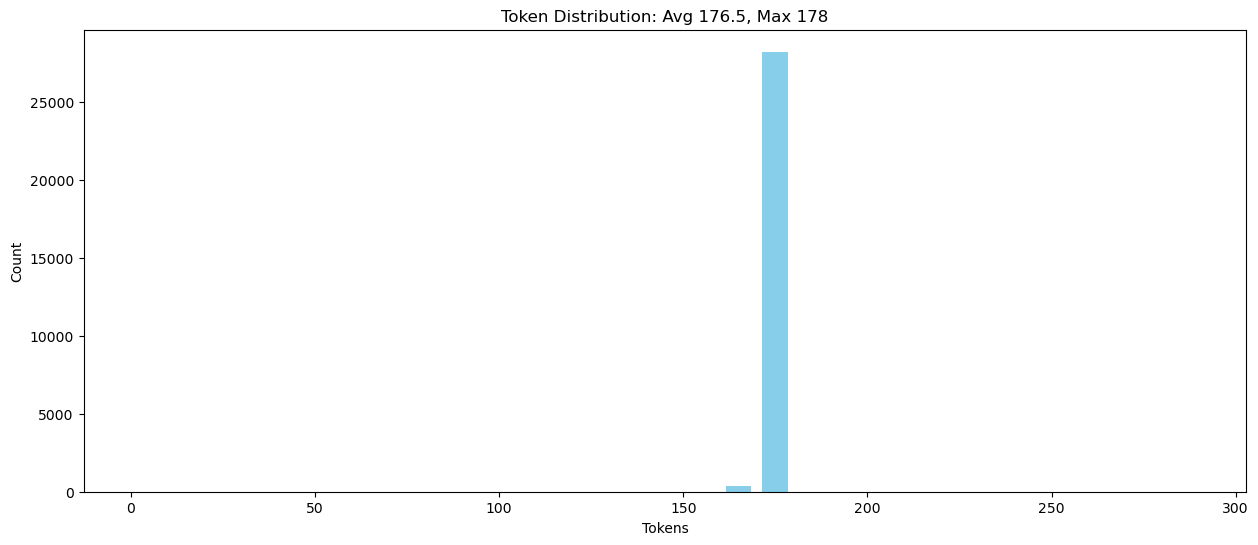

In [9]:
# Plot token count distribution
# Why: Understand the length of item descriptions for model input

tokens = [item.token_count for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Token Distribution: Avg {sum(tokens)/len(tokens):,.1f}, Max {max(tokens):,}")
plt.xlabel('Tokens')
plt.ylabel('Count')
plt.hist(tokens, rwidth=0.7, color="skyblue", bins=range(0, 300, 10))
plt.show()

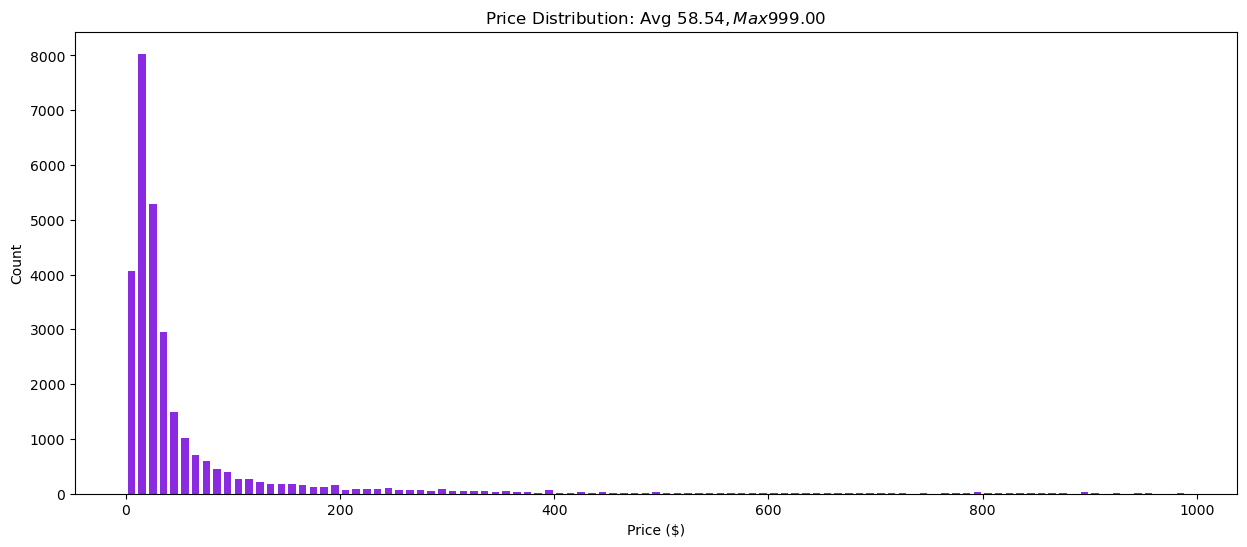

In [10]:
# Plot price distribution
# Why: Analyze price range to ensure dataset suitability

prices = [item.price for item in items]
plt.figure(figsize=(15, 6))
plt.title(f"Price Distribution: Avg ${sum(prices)/len(prices):,.2f}, Max ${max(prices):,.2f}")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="blueviolet", bins=range(0, 1000, 10))
plt.show()

## Dataset Validation

Verify the dataset's quality and characteristics.  


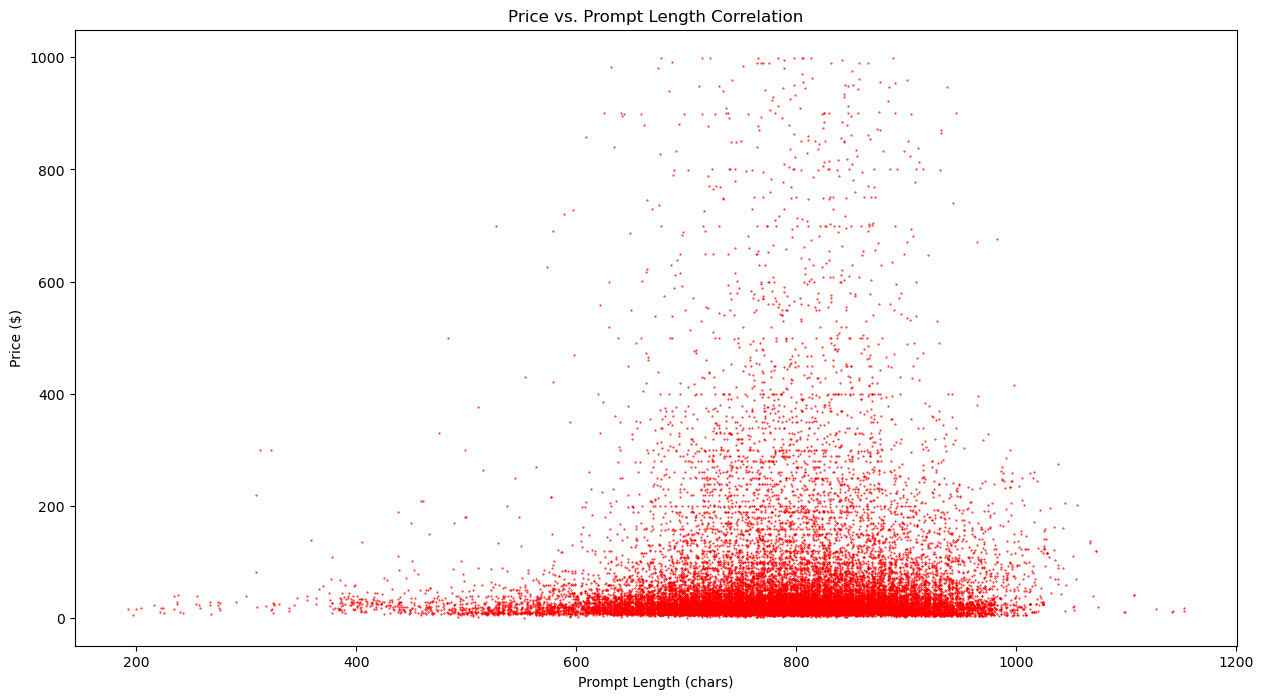

In [11]:
# Check if price correlates with prompt length
# Why: Explore if longer descriptions indicate higher prices

sample = items
sizes = [len(item.prompt) for item in sample]
prices = [item.price for item in sample]
plt.figure(figsize=(15, 8))
plt.scatter(sizes, prices, s=0.2, color="red")
plt.xlabel('Prompt Length (chars)')
plt.ylabel('Price ($)')
plt.title('Price vs. Prompt Length Correlation')
plt.show()

In [12]:
# Function to inspect item prompt and tokens
# Why: Debug and understand tokenization output

def report(item):
    prompt = item.prompt
    tokens = Item.tokenizer.encode(item.prompt)
    print(prompt)
    print(tokens[-10:])
    print(Item.tokenizer.batch_decode(tokens[-10:]))

In [13]:
# Inspect a sample item
report(sample[59])

How much does this cost to the nearest dollar?

GE Part Number KNOB-ROTARY
Genuine Original Equipment Manufacturer (OEM) parts! This control knob (part number is for dryers. Control knob lets you control cycle settings. Remove the knob by pulling it straight off its post. This part is compatible with models including; Control knob lets you control cycle settings Genuine Original Equipment Manufacturer (OEM) part. Compatible Brands Ge This control knob (part number is for dryers Remove the knob by pulling it straight off its post Manufacturer GE, Part Weight 3.19 ounces, Dimensions 5.7 x 5.6 x 1.3 inches, Country of Origin USA, model number Is Discontinued No, Style Compatible, Finish Polished, Quantity 1, Included Components Knob, Rank Tools & Home Improvement

Price is $36.00
[612, 5492, 53751, 271, 7117, 374, 400, 1927, 13, 410]
[' &', ' Home', ' Improvement', '\n\n', 'Price', ' is', ' $', '36', '.', '00']


## Tokenizer Behavior

**What**: Llama tokenizer maps numbers 1–999 to single tokens.  
**Why**: This reduces token count for prices, aiding model efficiency.  
**How**: Unlike Qwen2, Gemma, or Phi3, which tokenize digits individually, Llama simplifies numeric representation.

## Train-Test Split

**What**: Divide data into training (25,000 items) and test (2,000 items) sets.  
**Why**: Ensure sufficient training data while reserving a test set for evaluation.  
**How**: Randomly shuffle and split the dataset with a fixed seed for reproducibility.

In [14]:
# Shuffle and split data
# Why: Random split ensures unbiased training and testing

random.seed(42)
random.shuffle(sample)
train = sample[:25_000]
test = sample[25_000:27_000]
print(f"Training set: {len(train):,} items, Test set: {len(test):,} items")

Training set: 25,000 items, Test set: 2,000 items


In [15]:
# Preview a training prompt
print(train[0].prompt)

How much does this cost to the nearest dollar?

and Replacement Range Cooktop Drip Pans fit GE, Hotpoint - Two 6 Inch and Two 8 Inch Pans (4 pieces)
Contents 2 x (6 inches) and 2 x (8 inches) bowls, 4 drip bowls total Compatibility This replacement kit works with GE, Hotpoint, Moffat, Monogram (GE), Profile (GE), RCA (GE), and Roper models prior to 1996. replaces 65975, replaces and 65974, 770169 Premium quality Drip bowls are made of durable high-quality material. It features a chrome finish, well-tested by the manufacturer. Durable, stick-free, easy to clean, and dishwasher safe. Ensure long-lasting and effective performance Easy to install Shut off electrical power, tilt the coil

Price is $12.00


In [16]:
# Preview a test prompt
print(test[0].test_prompt())

How much does this cost to the nearest dollar?

Setpower Insulated Protective Cover for AJ30 Portable Refrigerator Freezer, suitable for AJ30 Only
Insulation & Waterproof well-made insulation could save battery power and improve cooling efficiency by preventing cold air from flowing away. Durable and Foldable with its oxford cloth outer layer, it's durable and protects your portable refrigerator from scratches and dust. Expanded Bag for Accessories two expanded bags on its side, expand space to store the other accessories. Great Ventilation a hollowed design for positions of vents doesn't affect the ventilation. Attention this insulated cover is ONLY suitable for SetPower AJ30 portable refrigerator. FIT TO AJ30 ONLY. Brand Name Setpower, Model Info AJ30 COVER, model number AJ30 COVER, Installation Type Freestanding, Part AJ30 cover, Special Features Portable, Color

Price is $


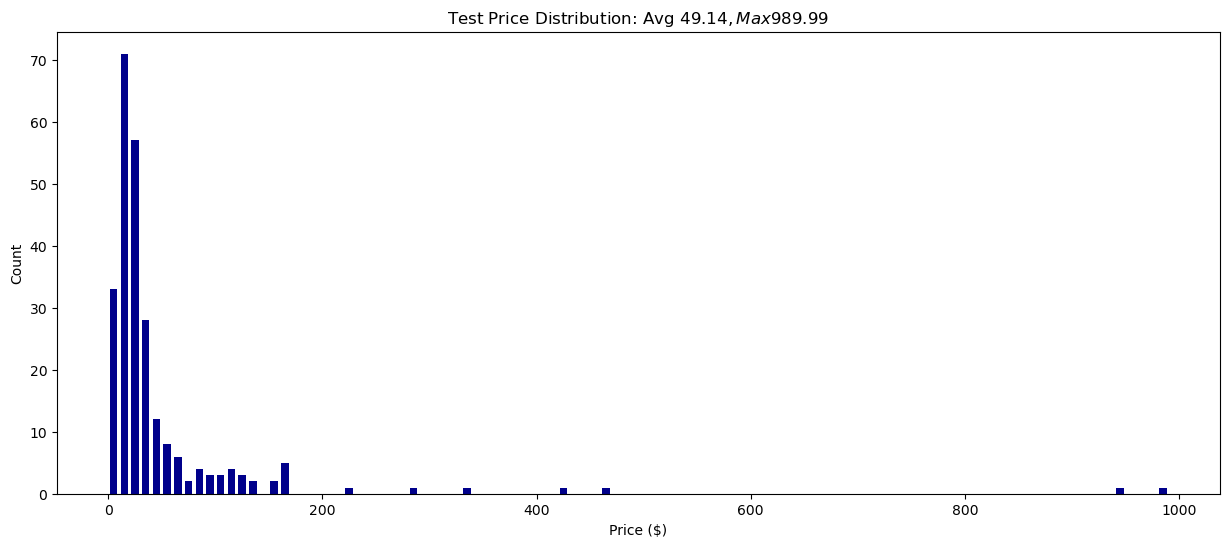

In [17]:
# Visualize price distribution of first 250 test items
# Why: Confirm test set price range is representative

prices = [float(item.price) for item in test[:250]]
plt.figure(figsize=(15, 6))
plt.title(f"Test Price Distribution: Avg ${sum(prices)/len(prices):,.2f}, Max ${max(prices):,.2f}")
plt.xlabel('Price ($)')
plt.ylabel('Count')
plt.hist(prices, rwidth=0.7, color="darkblue", bins=range(0, 1000, 10))
plt.show()

## Dataset Upload
Convert data to prompts and upload to HuggingFace Hub.  


In [18]:
# Prepare prompts and prices
# Why: Format data for model training

train_prompts = [item.prompt for item in train]
train_prices = [item.price for item in train]
test_prompts = [item.test_prompt() for item in test]
test_prices = [item.price for item in test]

In [19]:
# Create structured dataset
# Why: Organize data for easy access and training

train_dataset = Dataset.from_dict({"text": train_prompts, "price": train_prices})
test_dataset = Dataset.from_dict({"text": test_prompts, "price": test_prices})
dataset = DatasetDict({
    "train": train_dataset,
    "test": test_dataset
})

In [20]:
# Upload to HuggingFace Hub
DATASET_NAME = "ishant24/lite-data"
dataset.push_to_hub(DATASET_NAME, private=True)

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/25 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        : 100%|##########| 9.73MB / 9.73MB            

Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Creating parquet from Arrow format:   0%|          | 0/2 [00:00<?, ?ba/s]

Processing Files (0 / 0)                : |          |  0.00B /  0.00B            

New Data Upload                         : |          |  0.00B /  0.00B            

                                        : 100%|##########|  771kB /  771kB            

README.md:   0%|          | 0.00/412 [00:00<?, ?B/s]

c:\Users\thund\anaconda3\envs\llms\Lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\thund\.cache\huggingface\hub\datasets--ishant24--lite-data. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
No files have been modified since last commit. Skipping to prevent empty commit.


CommitInfo(commit_url='https://huggingface.co/datasets/ishant24/lite-data/commit/a9e4871c7348c0b5abc9d762abaea386db6a218c', commit_message='Upload dataset', commit_description='', oid='a9e4871c7348c0b5abc9d762abaea386db6a218c', pr_url=None, repo_url=RepoUrl('https://huggingface.co/datasets/ishant24/lite-data', endpoint='https://huggingface.co', repo_type='dataset', repo_id='ishant24/lite-data'), pr_revision=None, pr_num=None)

In [21]:
# Save datasets locally as pickle files
# Why: Enable quick loading without reprocessing

with open('train_lite.pkl', 'wb') as file:
    pickle.dump(train, file)
with open('test_lite.pkl', 'wb') as file:
    pickle.dump(test, file)